In [1]:
import function_sleepWakeLabels as sleep
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import glob
import re
from os.path import join
from datetime import date
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from tqdm.notebook import tqdm
import pickle

sns.set_theme(style="darkgrid")

In [2]:
dat_dir = '/Users/loranknol/HPC_project/data/'

all_files = sorted(glob.glob("sub-*/preproc/*dat-kp.csv", root_dir=dat_dir, recursive=True))

pat = re.compile(r"sub-(\d+)")
subs = [re.match(pat, f).group(1) for f in all_files]

In [4]:
gsvd_results = {}

for (sub, file) in tqdm(zip(subs, all_files)):
    # read in keypress file
    dfKP = pd.read_csv(join(dat_dir, file), index_col=0)
    dfKP['date'] = pd.to_datetime(dfKP['keypressTimestampLocal']) \
        .map(lambda x: x.date())
    dfKP['dayNumber'] = dfKP['date'].rank(method='dense')

    # Necessary for joining sleep self-report to the key press data
    dates = dfKP[['date', 'dayNumber']].drop_duplicates()

    ################################################################
    # FIND SLEEP/WAKE LABELS FROM BIAFFECT KEYPRESS DATA FILE
    ################################################################
    # STEP 1
    # get input matrices of shape days x hours for typing activity (nKP) and speed (median IKD)
    ## matrices may have missing days
    ## check index here to identify day number since first date of typing data
    Mactivity, Mspeed = sleep.get_typingMatrices(dfKP)

    if Mactivity.empty:
        print("Not enough data, skipping subject {}".format(sub))
        continue

    # STEP 2
    # get graph regularized SVD
    svd = sleep.get_SVD(Mactivity, Mspeed)

    # STEP 3
    # get sleep/wake labels by hour
    sleepMatrix = sleep.get_sleepWakeLabels(svd)

    gsvd_results[sub] = {
        'dates': dates,
        'Mactivity': Mactivity,
        'Mspeed': Mspeed,
        'svd': svd,
        'sleepMatrix': sleepMatrix
    }

with open(join(dat_dir, 'gsvd_results.pkl'), 'wb') as handle:
    pickle.dump(gsvd_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

0it [00:00, ?it/s]

Not enough data, skipping subject 3004
Not enough data, skipping subject 3006


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [3]:
with open(join(dat_dir, 'gsvd_results.pkl'), 'rb') as handle:
    gsvd_results = pickle.load(handle)

In [4]:
self_reports_raw = pd.read_csv(join(dat_dir, "clear3daily_20221205.csv"), index_col=0)
self_reports = self_reports_raw[['id', 'daterated', 'sleepdur_yest', 'SleepLNQuality']]
self_reports = self_reports.dropna()
self_reports['daterated'] = self_reports['daterated'].map(lambda d: date.fromisoformat(d))
self_reports

/var/folders/p7/qsy7v2sd3_j1ypyqv03cpv7r0000gp/T/ipykernel_2022/4202685588.py:1: DtypeWarning: Columns (5,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,126,128,136,137,138,139,140,142,145,150,151,156,158) have mixed types. Specify dtype option on import or set low_memory=False.
  self_reports_raw = pd.read_csv(join(dat_dir, "clear3daily_20221205.csv"), index_col=0)


,id,daterated,sleepdur_yest,SleepLNQuality
1,3001,2020-11-14,2.0,2.0
2,3001,2020-11-15,4.0,2.0
3,3001,2020-11-16,4.0,2.0
4,3001,2020-11-17,5.0,3.0
5,3001,2020-11-18,7.0,3.0
...,...,...,...,...
32749,3118,2022-11-10,5.0,2.0
32750,3118,2022-11-11,4.0,2.0
32751,3118,2022-11-12,4.0,2.0
32753,3118,2022-11-14,5.0,2.0


In [50]:
# I don't want all these plots embedded in this notebook
backend = mpl.rcParams['backend']
mpl.use("agg")

cors = {}
sleep_scores = {}

for sub, res in gsvd_results.items():
    Mactivity = res['Mactivity']
    Mspeed = res['Mspeed']
    svd = res['svd']
    sleepMatrix = res['sleepMatrix']

    # Plot steps if desired
    plot = sleep.plot_heatmaps(Mactivity, Mspeed, svd, sleepMatrix)
    plot.savefig("images/matrices_sub-{}.png".format(sub), dpi=300)
    plt.close()

    sr_sub = self_reports.loc[self_reports['id'] == int(sub)]

    # Fuse self-report with day numbers
    merged = res['dates'].merge(sr_sub, how='outer', left_on='date', right_on='daterated')
    sub_sleep_scores = merged[['dayNumber', 'sleepdur_yest', 'SleepLNQuality']]

    # Fuse self-report with predicted sleep scores
    days = Mactivity.index
    sleep_pred = np.sum(1 - sleepMatrix, axis=1)
    sleep_pred = pd.DataFrame({'dayNumber': days.values, 'sleep_pred': sleep_pred})
    sub_sleep_scores = sub_sleep_scores.merge(sleep_pred, how='outer', on='dayNumber')
    sleep_scores[sub] = sub_sleep_scores
    
    ### Plot sleep duration
    fig = plt.figure(layout="constrained")

    fig.suptitle("Sleep duration sub {}".format(sub))

    gs = GridSpec(1, 5, fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2:], sharey=ax1)

    ax1.plot(sub_sleep_scores['sleepdur_yest'], sub_sleep_scores['dayNumber'])
    ax1.invert_yaxis()
    ax1.set_title('Reported')

    ax2.plot(sub_sleep_scores['sleep_pred'], sub_sleep_scores['dayNumber'])
    ax2.set_title('Predicted')
    plt.setp(ax2.get_yticklabels(), visible=False)

    sns.heatmap(svd, cmap='viridis', ax=ax3,
                cbar_kws={'label': 'Typing intensity', 'fraction': 0.043})
    plt.setp(ax3.get_yticklabels(), visible=False)

    plt.savefig("images/duration_sub-{}.png".format(sub), dpi=300)

    plt.close()

    ### Plot sleep quality
    fig = plt.figure(layout="constrained")

    fig.suptitle("Sleep quality sub {}".format(sub))

    gs = GridSpec(1, 5, fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2:], sharey=ax1)

    ax1.plot(sub_sleep_scores['SleepLNQuality'], sub_sleep_scores['dayNumber'])
    ax1.invert_yaxis()
    ax1.set_title('Reported')

    ax2.plot(sub_sleep_scores['sleep_pred'], sub_sleep_scores['dayNumber'])
    ax2.set_title('Predicted')
    plt.setp(ax2.get_yticklabels(), visible=False)

    sns.heatmap(svd, cmap='viridis', ax=ax3,
                cbar_kws={'label': 'Typing intensity', 'fraction': 0.043})
    plt.setp(ax3.get_yticklabels(), visible=False)

    plt.savefig("images/quality_sub-{}.png".format(sub), dpi=300)

    plt.close()

    ### Scatter plot
    ss_complete = sub_sleep_scores.dropna()

    if len(ss_complete.index) < 2:
        cor = 0.0
        p_cor = 1.0
    else:
        cor_res = pearsonr(ss_complete['sleepdur_yest'], ss_complete['sleep_pred'])
        cor = cor_res.statistic
        p_cor = cor_res.pvalue

    cors[sub] = {
        'cor': cor,
        'p_cor': p_cor
    }

    sns.stripplot(sub_sleep_scores, x="sleepdur_yest", y="sleep_pred", alpha=0.4) \
        .set(
            title=fr"Sub {sub}, $\rho$ = {cor:.2f} (p = {p_cor:.2g})",
            xlabel="Reported sleep duration (hours)",
            ylabel="Predicted sleep duration (hours)"
        )

    plt.savefig("images/scatter_sub-{}.png".format(sub), dpi=300)

    plt.close()

mpl.use(backend)

In [56]:
sleep_scores_df = pd.concat(sleep_scores).reset_index(0, names="id")
sleep_scores_df.to_csv(join(dat_dir, "sleep_scores.csv"), index=False)

In [6]:
cors = {}

for sub, res in gsvd_results.items():
    Mactivity = res['Mactivity']
    Mspeed = res['Mspeed']
    svd = res['svd']
    sleepMatrix = res['sleepMatrix']

    sr_sub = self_reports.loc[self_reports['id'] == int(sub)]

    # Fuse self-report with day numbers
    merged = res['dates'].merge(sr_sub, how='outer', left_on='date', right_on='daterated')
    sub_sleep_scores = merged[['dayNumber', 'sleepdur_yest', 'SleepLNQuality']]

    # Fuse self-report with predicted sleep scores
    days = Mactivity.index
    sleep_pred = np.sum(1 - sleepMatrix, axis=1)
    sleep_pred = pd.DataFrame({'dayNumber': days.values, 'sleep_pred': sleep_pred})
    sub_sleep_scores = sub_sleep_scores.merge(sleep_pred, how='outer', on='dayNumber')

    ss_complete = sub_sleep_scores.dropna()

    if len(ss_complete.index) < 2:
        cor = 0.0
        p_cor = 1.0
    else:
        cor_res = pearsonr(ss_complete['sleepdur_yest'], ss_complete['sleep_pred'])
        cor = cor_res.statistic
        p_cor = cor_res.pvalue

    cors[sub] = {
        'cor': cor,
        'p_cor': p_cor
    }

Analyse the relationships between high correlation values and subject data characteristics

In [7]:
zipped = list(zip(*cors.items()))
cor_subs = [int(id) for id in zipped[0]]
(cor_cors, cor_pvals) = list(zip(*[d.values() for d in zipped[1]]))

cor_df = pd.DataFrame({'id': cor_subs, 'correlation': cor_cors, 'pvalue': cor_pvals})

In [8]:
cor_reports = self_reports.merge(cor_df, how='outer', on='id')
cor_reports = cor_reports.loc[~np.isnan(cor_reports['correlation'])]
cor_reports = cor_reports.groupby('id').agg(
    n=pd.NamedAgg('sleepdur_yest', 'size'),
    correlation=pd.NamedAgg('correlation', 'first')
)

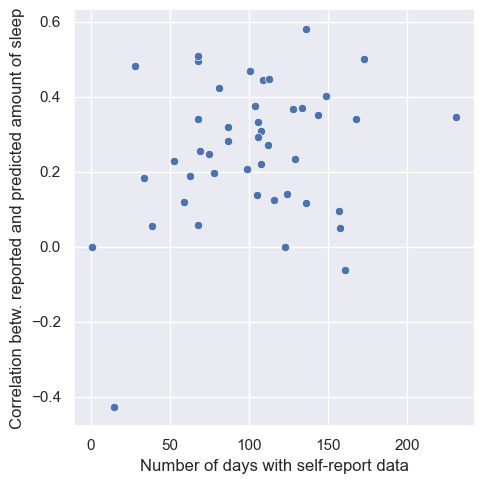

In [35]:
%matplotlib inline

sns.relplot(cor_reports, x='n', y='correlation') \
    .set(
        xlabel="Number of days with self-report data",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_days_self-report.png", dpi=300)

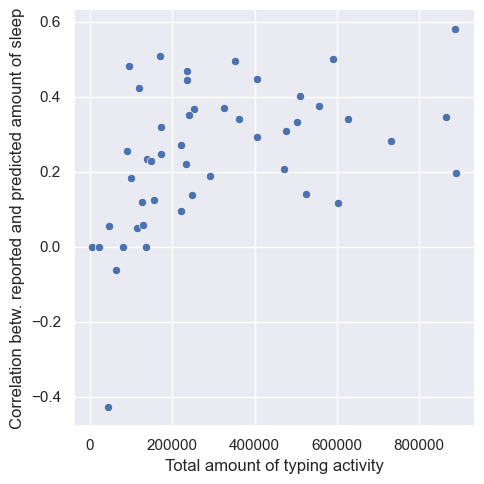

In [40]:
total_activities = [np.sum(np.array(res['Mactivity'])) for res in gsvd_results.values()]
cor_reports['activity'] = total_activities

sns.relplot(cor_reports, x='activity', y='correlation')\
    .set(
        xlabel="Total amount of typing activity",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_activity.png", dpi=300)

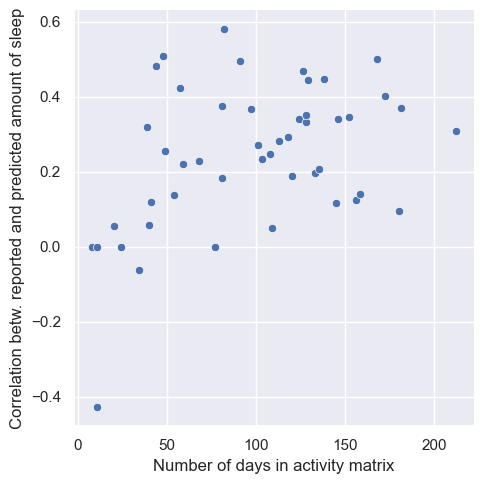

In [41]:
cor_reports['n_matrix'] = [len(res['Mactivity'].index) for res in gsvd_results.values()]

sns.relplot(cor_reports, x='n_matrix', y='correlation')\
    .set(
        xlabel="Number of days in activity matrix",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_days_mat.png", dpi=300)

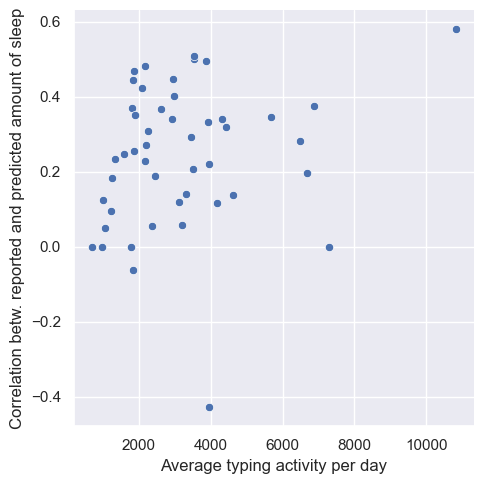

In [45]:
mats = [np.array(res['Mactivity']) for res in gsvd_results.values()]
cor_reports['activity_per_day'] = [np.sum(mat) / mat.shape[0] for mat in mats]

sns.relplot(cor_reports, x='activity_per_day', y='correlation')\
    .set(
        xlabel="Average typing activity per day",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_activity_per_day.png", dpi=300)

In [5]:
sr_sub = self_reports.loc[self_reports['id'] == int(subs[2])]
sr_sub

,id,daterated,sleepdur_yest,SleepLNQuality
3228,3009,2021-01-13,6.0,3.0
3229,3009,2021-01-14,5.0,2.0
3230,3009,2021-01-15,5.0,3.0
3231,3009,2021-01-16,5.0,3.0
3232,3009,2021-01-17,5.0,2.0
...,...,...,...,...
3403,3009,2021-07-07,6.0,2.0
3404,3009,2021-07-08,6.0,2.0
3405,3009,2021-07-09,8.0,2.0
3406,3009,2021-07-10,7.0,3.0


In [6]:
merged = dfKP.merge(sr_sub, how='outer', left_on='date', right_on='daterated')
merged

,healthCode,recordId,createdOnTimestamp,createdOnTimeZone,appVersion,phoneInfo,sessionDuration,timestamp,keypress_type,keypress_duration,...,IKD,previousKeyType,handedness,date,dayNumber,hour,id,daterated,sleepdur_yest,SleepLNQuality
0,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.083155,...,NaN,NaN,two-handed,2021-01-13,1.0,9,3009.0,2021-01-13,6.0,3.0
1,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.082185,...,0.313727,alphanum,two-handed,2021-01-13,1.0,9,3009.0,2021-01-13,6.0,3.0
2,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.082252,...,0.175755,alphanum,two-handed,2021-01-13,1.0,9,3009.0,2021-01-13,6.0,3.0
3,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.074835,...,0.458351,alphanum,two-handed,2021-01-13,1.0,9,3009.0,2021-01-13,6.0,3.0
4,EC7bVNwYAmzxc-9klsv7NUwA,GKckD28sUvSwvLY1xZzHjvR7,1610551018626,-600,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.2",9.856795,1.610551e+09,alphanum,0.091569,...,0.166526,alphanum,two-handed,2021-01-13,1.0,9,3009.0,2021-01-13,6.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223287,EC7bVNwYAmzxc-9klsv7NUwA,mzVPNe2qQ6Ay-3DS2X9UbjIR,1626189777794,-500,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.6",14.997075,1.626190e+09,alphanum,0.108232,...,0.165735,alphanum,two-handed,2021-07-13,182.0,10,NaN,NaN,NaN,NaN
223288,EC7bVNwYAmzxc-9klsv7NUwA,mzVPNe2qQ6Ay-3DS2X9UbjIR,1626189777794,-500,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.6",14.997075,1.626190e+09,alphanum,0.099732,...,0.216877,alphanum,two-handed,2021-07-13,182.0,10,NaN,NaN,NaN,NaN
223289,EC7bVNwYAmzxc-9klsv7NUwA,mzVPNe2qQ6Ay-3DS2X9UbjIR,1626189777794,-500,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.6",14.997075,1.626190e+09,alphanum,0.090719,...,0.273869,alphanum,two-handed,2021-07-13,182.0,10,NaN,NaN,NaN,NaN
223290,EC7bVNwYAmzxc-9klsv7NUwA,mzVPNe2qQ6Ay-3DS2X9UbjIR,1626189777794,-500,"version 2.2.0, build 30","Unknown iPhone [iPhone12,1]; iOS/14.6",14.997075,1.626190e+09,alphanum,0.058250,...,0.367627,alphanum,two-handed,2021-07-13,182.0,10,NaN,NaN,NaN,NaN


In [7]:
sub_sleep_scores = merged[['dayNumber', 'sleepdur_yest', 'SleepLNQuality']].drop_duplicates()
sub_sleep_scores

,dayNumber,sleepdur_yest,SleepLNQuality
0,1.0,6.0,3.0
492,2.0,5.0,2.0
2014,3.0,5.0,3.0
2811,4.0,5.0,3.0
3397,5.0,5.0,2.0
...,...,...,...
220402,178.0,8.0,2.0
220608,179.0,7.0,3.0
221456,180.0,6.0,2.0
222163,181.0,NaN,NaN


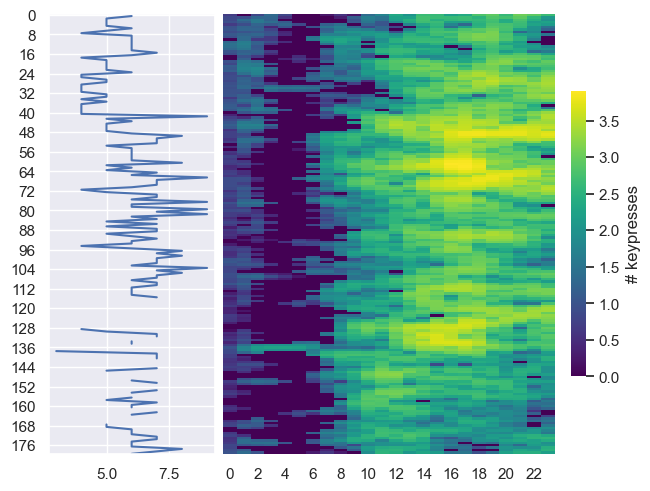

In [25]:
fig = plt.figure(layout="constrained")
gs = GridSpec(1, 3, fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:], sharey=ax1)

ax1.plot(sub_sleep_scores['sleepdur_yest'], sub_sleep_scores['dayNumber'])
ax1.invert_yaxis()
# sns.lineplot(sleep_scores, x='dayNumber', y='value', hue='variable', ax=ax2)
hm = sns.heatmap(svd, cmap='viridis', ax=ax2,
                 cbar_kws={'label': '# keypresses', 'fraction': 0.043})
plt.setp(ax2.get_yticklabels(), visible=False);

In [21]:
days = Mactivity.index
sleep_pred = np.sum(1 - sleepMatrix, axis=1)
sleep_pred = pd.DataFrame({'dayNumber': days.values, 'sleep_pred': sleep_pred})

sub_sleep_scores = sub_sleep_scores.merge(sleep_pred, how='outer', on='dayNumber')
sub_sleep_scores

,dayNumber,sleepdur_yest,SleepLNQuality,sleep_pred
0,1.0,6.0,3.0,NaN
1,2.0,5.0,2.0,2.0
2,3.0,5.0,3.0,3.0
3,4.0,5.0,3.0,5.0
4,5.0,5.0,2.0,4.0
...,...,...,...,...
177,178.0,8.0,2.0,3.0
178,179.0,7.0,3.0,7.0
179,180.0,6.0,2.0,7.0
180,181.0,NaN,NaN,7.0


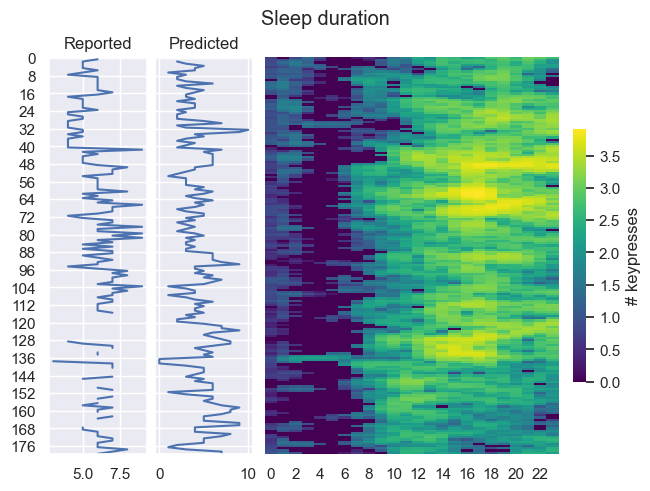

In [39]:
fig = plt.figure(layout="constrained")

fig.suptitle("Sleep duration")

gs = GridSpec(1, 5, fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2:], sharey=ax1)

ax1.plot(sub_sleep_scores['sleepdur_yest'], sub_sleep_scores['dayNumber'])
ax1.invert_yaxis()
ax1.set_title('Reported')

ax2.plot(sub_sleep_scores['sleep_pred'], sub_sleep_scores['dayNumber'])
ax2.set_title('Predicted')
plt.setp(ax2.get_yticklabels(), visible=False);

sns.heatmap(svd, cmap='viridis', ax=ax3,
            cbar_kws={'label': '# keypresses', 'fraction': 0.043})
plt.setp(ax3.get_yticklabels(), visible=False);

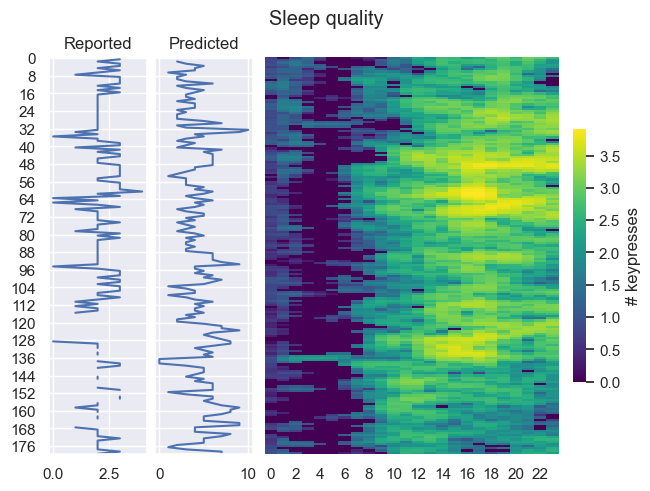

In [40]:
fig = plt.figure(layout="constrained")

fig.suptitle("Sleep quality")

gs = GridSpec(1, 5, fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2:], sharey=ax1)

ax1.plot(sub_sleep_scores['SleepLNQuality'], sub_sleep_scores['dayNumber'])
ax1.invert_yaxis()
ax1.set_title('Reported')

ax2.plot(sub_sleep_scores['sleep_pred'], sub_sleep_scores['dayNumber'])
ax2.set_title('Predicted')
plt.setp(ax2.get_yticklabels(), visible=False);

sns.heatmap(svd, cmap='viridis', ax=ax3,
            cbar_kws={'label': '# keypresses', 'fraction': 0.043})
plt.setp(ax3.get_yticklabels(), visible=False);

In [6]:
pearsonr(np.random.normal(size=100), np.random.normal(size=100)).correlation

0.02480989365043753

PearsonRResult(statistic=0.09495065756954787, pvalue=0.23837374143353948)


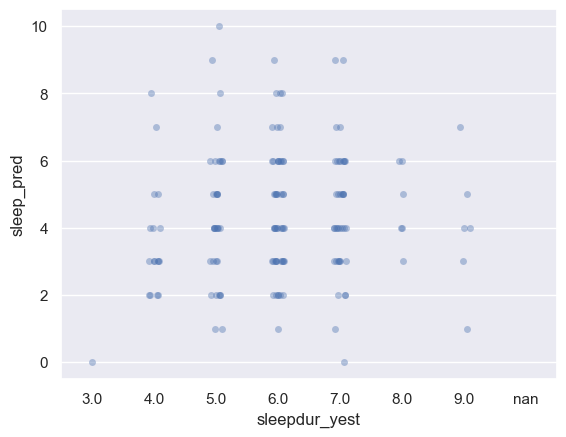

In [38]:
sns.stripplot(sub_sleep_scores, x="sleepdur_yest", y="sleep_pred", alpha=0.4)

ss_complete = sub_sleep_scores.dropna()
print(pearsonr(ss_complete['sleepdur_yest'], ss_complete['sleep_pred']))

PearsonRResult(statistic=-0.10565219497939611, pvalue=0.18929765221763328)


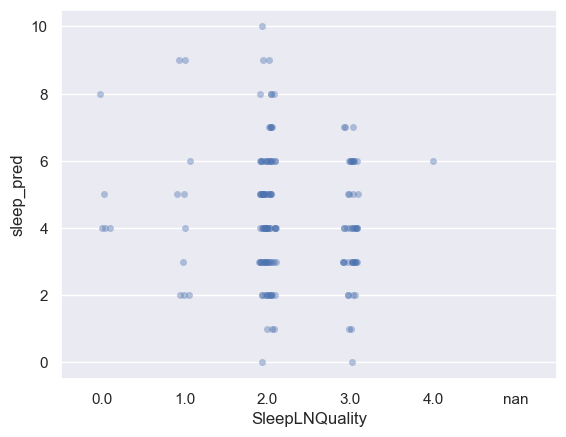

In [42]:
sns.stripplot(sub_sleep_scores, x="SleepLNQuality", y="sleep_pred", alpha=0.4)
print(pearsonr(ss_complete['SleepLNQuality'], ss_complete['sleep_pred']))